# Fine tuning SOTA models (BERT and RoBERTa) for Document Classification using Hugging Face

In this project, we will try to apply the transfer learning technique for NLP task. We will fine tune [BERT](https://arxiv.org/abs/1810.04805) and [RoBERTa](https://arxiv.org/abs/1907.11692) (maybe Longformers) to do text/document classification. Most of the content are taken from this [post] by aaaa. In addition, we attempt to make it as general as possible that it can be used for any similar models (thanks to the Transformers library from [hugging face](https://huggingface.co/)) with any dataset by doing just some miner changes. If we could, we may try to overcome the limitation of the 512-sequence length of BERT by segmenting the input into smaller text and feed each of them into BERT. Then we extract the representation of each text chunk from (output pooled) and feed the combined representation of each document to LSTM to classify long documents. We will see if this improve the results or overfit the data. This idea is presented by this [paper]( https://arxiv.org/abs/1910.10781). We mainly used **python, Transformers, Pytorch, Sklearn**

## Result Summary

- Accuraccy =  99.79%
- MCC = 99.58

## Setup


In [1]:
!nvidia-smi

Sat Nov 14 02:33:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [86]:
# !pip install -qq -r requirements.txt

In [4]:
# !pip install -qq transformers

In [3]:
# watermark: An IPython magic extension for printing date and time stamps, version numbers, and hardware information.
# !pip install -q -U watermark

In [84]:
%watermark

2020-11-14T03:47:00+00:00

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


In [85]:
%watermark -v -p numpy,pandas,torch,transformers,seaborn,nltk

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.4
torch 1.7.0+cu101
transformers 3.5.1
seaborn 0.11.0
nltk 3.2.5


In [6]:
import transformers
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 10, 6


## Config

In [7]:
MAX_LEN = 160
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
BERT_PATH = "../input/bert-base-uncased"
MODEL_PATH = "/root/docker_data/model.bin"
TRAINING_FILE = "../input/train.csv"

PRE_TRAINED_MODEL = 'roberta-base'
# TOKENIZER = transformers.BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)
TOKENIZER = transformers.RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL)
PT_MODEL = transformers.RobertaModel.from_pretrained(PRE_TRAINED_MODEL)



# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

In [8]:
RANDOM_SEED = 42
EPOCHS = 4
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
x = "aaa_"+ BERT_PATH + "_aaa"
x

'aaa_../input/bert-base-uncased_aaa'

## Data Preprocessing



In [10]:
!unzip news.csv.zip

Archive:  news.csv.zip
replace news.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [11]:
# df = pd.read_csv("reviews.csv")
df = pd.read_csv('news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [12]:
# df = df.rename(columns = {'Content':'text', 'Category':'label'})

In [13]:
classes = np.unique(df.label)
classes

array(['FAKE', 'REAL'], dtype=object)

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.label = le.fit_transform(df.label)
df.head(3)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1


In [15]:
CLASS_NAMES = np.unique(le.inverse_transform(df.label))

In [16]:
df.shape

(6335, 4)

We have about 16k examples. Let's check for missing values:

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 198.1+ KB


Great, no missing values in the score and review texts! Do we have class imbalance?

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


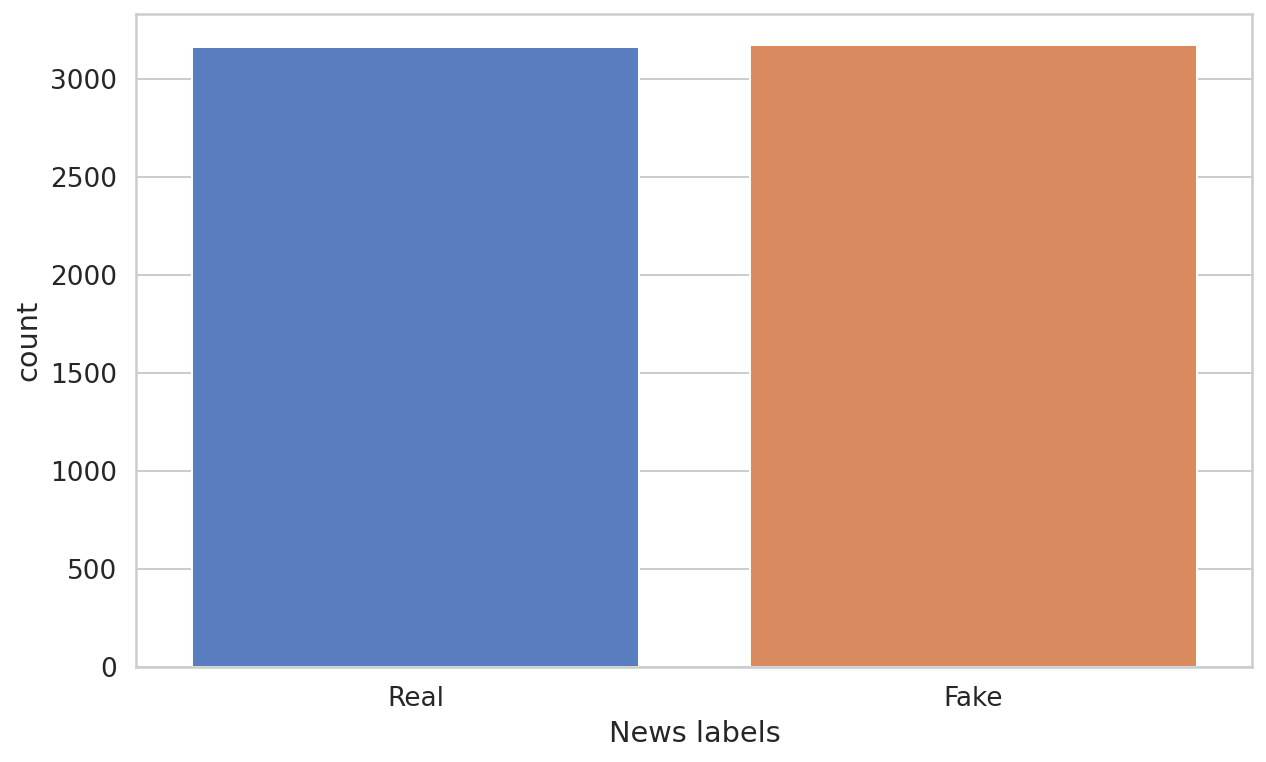

In [19]:
ax = sns.countplot(df.label)
plt.xlabel('News labels')
ax.set_xticklabels(CLASS_NAMES);

The balance was (mostly) restored.

In [20]:
# df['label'].replace({'REAL':0, 'FAKE':1}, inplace=True)
# df.head()

## PyTorch Dataset and DataLoader

In [21]:
class NewsDataset(Dataset):

  def __init__(self, news_texts, labels, tokenizer, max_len):
    self.news_texts = news_texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.news_texts)
  
  def __getitem__(self, item):
    news_Text = str(self.news_texts[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      news_Text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      # pad_to_max_length=True,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'news_Text': news_Text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [22]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((5384, 4), (475, 4), (476, 4))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [23]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = NewsDataset(
    news_texts=df.text.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [24]:
train_data_loader = create_data_loader(df_train, TOKENIZER, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, TOKENIZER, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, TOKENIZER, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [25]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['news_Text', 'input_ids', 'attention_mask', 'labels'])

In [26]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([32, 160])
torch.Size([32, 160])
torch.Size([32])


## The Classification Model

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our classifier on top of it.

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [29]:
class NewsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(NewsClassifier, self).__init__()
    self.pretrained_model = PT_MODEL
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.pretrained_model.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.pretrained_model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [30]:
model = NewsClassifier(len(CLASS_NAMES))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [31]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # {batch size , seq length]
print(attention_mask.shape) # [batch size , seq length]

torch.Size([32, 160])
torch.Size([32, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [83]:
# F.softmax(model(input_ids, attention_mask), dim=1)

### Training the model

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [33]:
optimizer = transformers.AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

Let's continue with writing a helper function for training our model for one epoch:

In [34]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [35]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history (similare to Scikit-Learn Library)

In [36]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Training Epoch {epoch + 1}/{EPOCHS}')
  print('*' * 20)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss}  ---  Train accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val  loss {val_loss}   ---   Val  accuracy {val_acc}')
  print('-' * 60)
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), PRE_TRAINED_MODEL + '_best_model.bin')
    best_accuracy = val_acc

Training Epoch 1/4
********************
Train loss 0.09411958335814777  ---  Train accuracy 0.9628528974739969
Val  loss 0.07204498635061705   ---   Val  accuracy 0.9873684210526316
------------------------------------------------------------

Training Epoch 2/4
********************
Train loss 0.023832277176982983  ---  Train accuracy 0.9944279346210995
Val  loss 0.010668487308915548   ---   Val  accuracy 0.9978947368421053
------------------------------------------------------------

Training Epoch 3/4
********************
Train loss 0.004676476175583053  ---  Train accuracy 0.9988855869242199
Val  loss 0.00014061883193789982   ---   Val  accuracy 1.0
------------------------------------------------------------

Training Epoch 4/4
********************
Train loss 0.0008868829434117256  ---  Train accuracy 0.99981426448737
Val  loss 0.001295058848336339   ---   Val  accuracy 1.0
------------------------------------------------------------

CPU times: user 6min 25s, sys: 4min 47s, total:

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

We can look at the training vs validation accuracy:

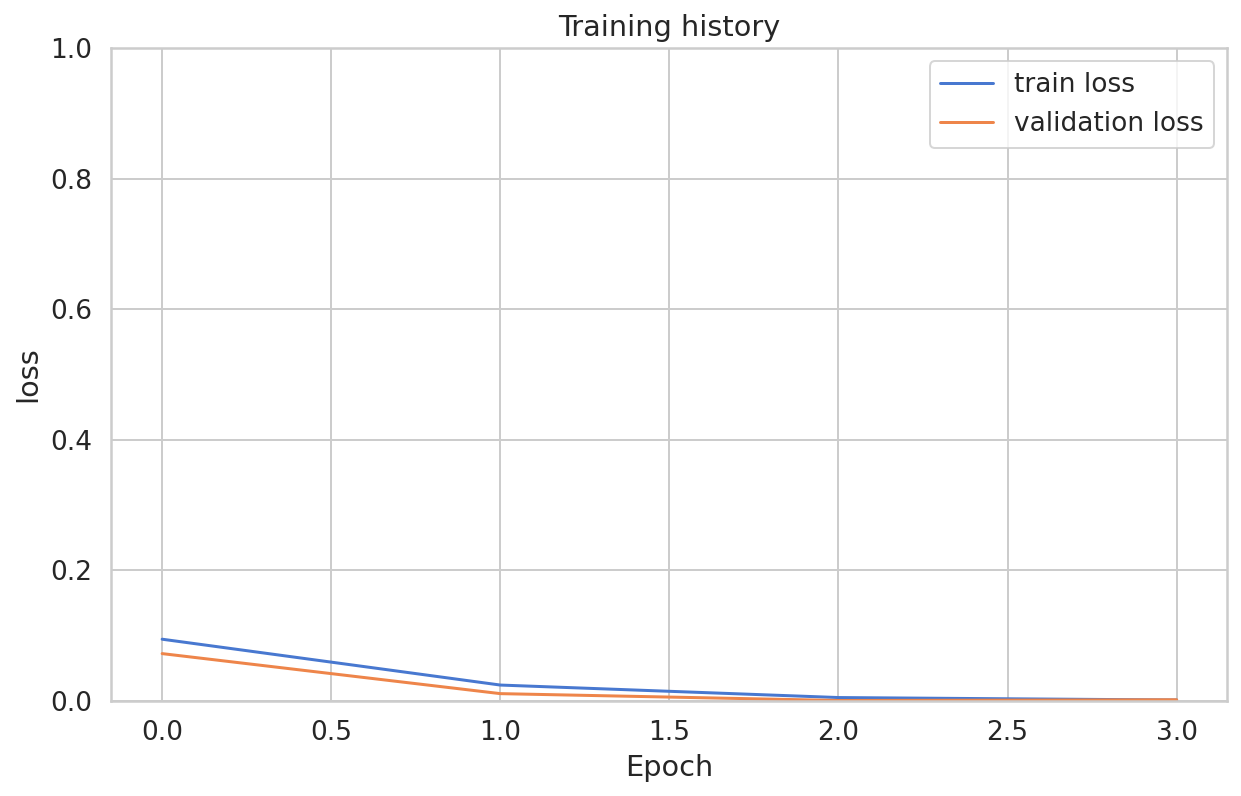

In [64]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

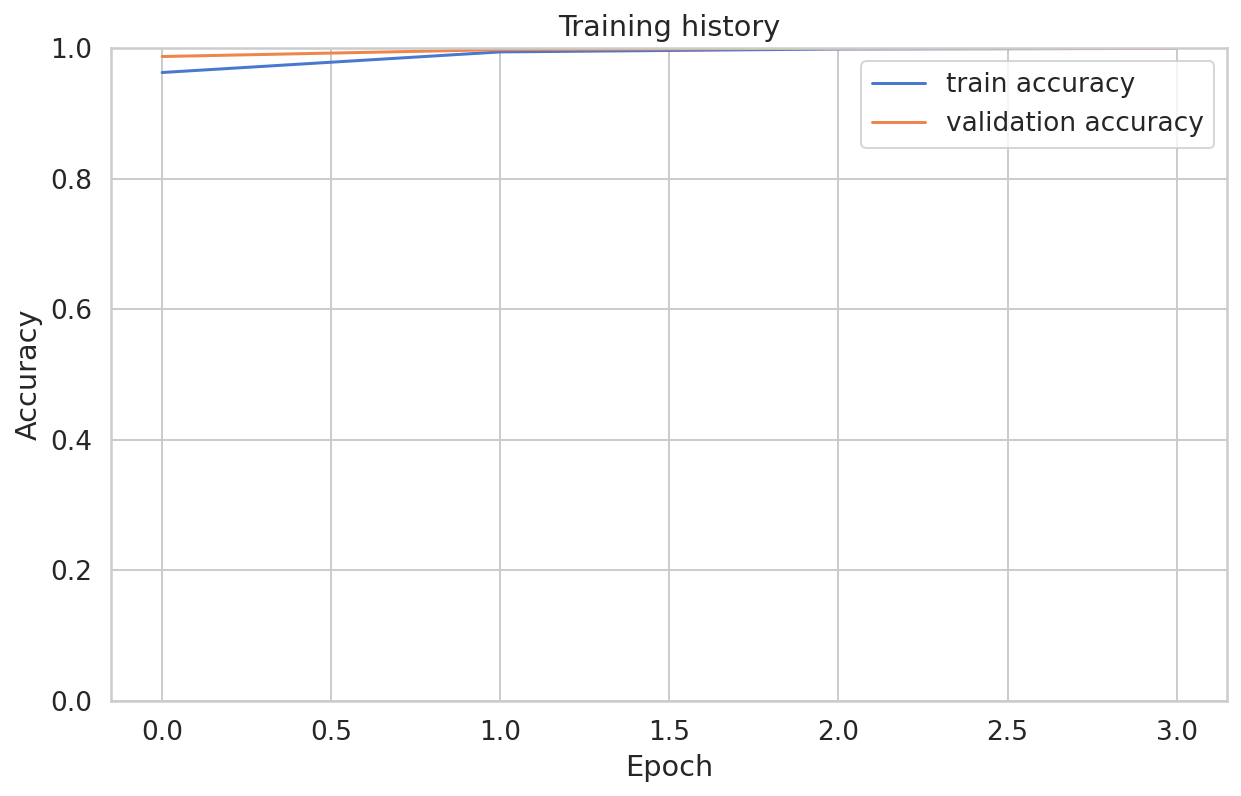

In [39]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 2 epochs or so.

In [63]:
# loading a pretrained model

# model = NewsClassifier(len(CLASS_NAMES))
# model.load_state_dict(torch.load(PRE_TRAINED_MODEL + '_best_model.bin'))
# model = model.to(device)

### Testing and evaluating the model

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [41]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

print('Accuraccy = ' , test_acc.item() * 100, '%')

Accuraccy =  99.78991596638656 %


The accuracy is about 1% lower on the test set. Our model seems to generalize well.



We'll define a helper function to get the predictions from our model:

In [42]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  news_Texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["news_Text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      news_Texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(labels)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return news_Texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [43]:
y_news_Texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Let's have a look at the classification report

In [44]:
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4))

              precision    recall  f1-score   support

        Real     1.0000    0.9955    0.9978       224
        Fake     0.9960    1.0000    0.9980       252

    accuracy                         0.9979       476
   macro avg     0.9980    0.9978    0.9979       476
weighted avg     0.9979    0.9979    0.9979       476



In [45]:
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4))

              precision    recall  f1-score   support

        Real     1.0000    0.9955    0.9978       224
        Fake     0.9960    1.0000    0.9980       252

    accuracy                         0.9979       476
   macro avg     0.9980    0.9978    0.9979       476
weighted avg     0.9979    0.9979    0.9979       476




We'll continue with the confusion matrix:

In [47]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, y_pred)
print('MCC = ', mcc * 100, '%') 

MCC =  99.57915396878174 %


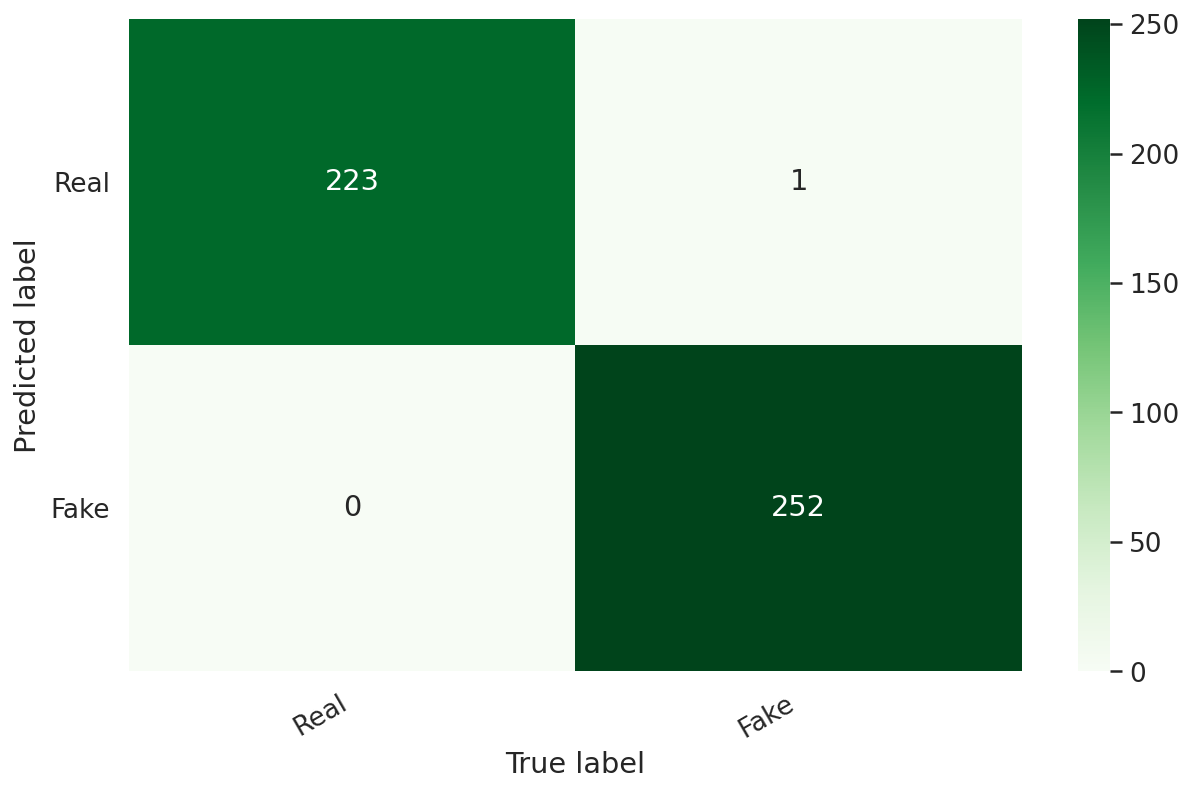

In [65]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.xlabel('True label')
  plt.ylabel('Predicted label');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
show_confusion_matrix(df_cm)


That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [72]:
idx = 1

news_text = y_news_Texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': CLASS_NAMES,
  'values': y_pred_probs[idx]})

In [74]:
print(pred_df.values)

[['FAKE' 4.324012479628436e-05]
 ['REAL' 0.9999567270278931]]


In [68]:
print(f'True Label: {le.inverse_transform([true_label])}')
print()
news_text2 = "\n".join(wrap(news_text))[:500]
# print("\n".join(wrap(news_text)))
print('Text:\n', news_text2)

True Label: ['REAL']

Text:
 This has been a rough year for pollsters and pundits, with prediction
after prediction going painfully awry. Even those supposedly
unflappable data journalists have found themselves stepping in it.
But it’s not just the journalists and pollsters. Since I’m a professor
of statistics as well as a blogger who often comments on academic
papers that I think misuse numbers, I have a front-row seat to some of
the least persuasive academic takes on politics and elections. And
it’s been a big year for ba


### Testing on raw text

Use the model to predict the label of some raw text. Using !!! should affect the predection.

In [58]:
News_text = 'This is real news!!!'

We have to use the tokenizer to encode the text:

In [59]:
encoded_text = TOKENIZER.encode_plus(
    News_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    return_token_type_ids=False,
    # pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt')

Let's get the predictions from our model:

In [78]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
probs = F.softmax(output, dim=1)
prediction_probs = torch.detach(probs).cpu()
# print(prediction)
print(f'Predected Label: {CLASS_NAMES[prediction]}')

pred_df = pd.DataFrame({
  'class_names': CLASS_NAMES,
  'values': y_pred_probs[idx]
})
print(pred_df.values)

Predected Label: Fake
[['Real' 4.324012479628436e-05]
 ['Fake' 0.9999567270278931]]



Lets try the same text without using the !!!.

In [82]:
News_text = 'This is real news.'

encoded_text = TOKENIZER.encode_plus(
    News_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt')

input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
probs = F.softmax(output, dim=1)
prediction_probs = torch.detach(probs).cpu()
# print(prediction)
print(f'Predected Label: {CLASS_NAMES[prediction]}')

pred_df = pd.DataFrame({
  'class_names': CLASS_NAMES,
  'values': y_pred_probs[idx]
})

print(pred_df.values)

Predected Label: Fake
[['Real' 4.324012479628436e-05]
 ['Fake' 0.9999567270278931]]


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [Hierarchical Transformers for Long Document Classification](https://arxiv.org/abs/1910.10781)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)